In [ ]:
%pip install -q matplotlib 
%pip install -q seaborn
%pip install -q pandas
%pip install -q numpy

In [49]:
import matplotlib.pyplot as plt 
import matplotlib.patheffects as pe
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd
import numpy as np
import os 
import re

In [64]:
ior_results_dir = "ior_results"

# for each csv in each dir
# take the highest bandwidth row
df = pd.DataFrame()
for dir in os.listdir(ior_results_dir):
    dir_path = os.path.join(ior_results_dir, dir)
    for file_name in os.listdir(dir_path):
        if file_name.endswith('.csv'): 
            file = os.path.join(dir_path, file_name)
            tmp = pd.read_csv(file)
            tmp = (tmp.iloc[tmp.idxmax(numeric_only=True)['bw(MiB/s)']].to_frame().T)
            tmp['fromCSV'] = file_name
            tmp['segments'] = re.search(r'.*_seg-(\d+)_.*', file).group(1)
            df = pd.concat([df,tmp], ignore_index=True)


df['nnodes'] = df['fromCSV'].str.extract(r'.*_n-(\d+)_.*')
df['nnodes'] = df['nnodes'].astype(int)
df['segments'] = df['segments'].astype(int)
df['block(KiB)'] = df['block(KiB)'].astype(int)
df['xfer(KiB)'] = df['xfer(KiB)'].astype(int)

# IOR_TX_SIZES=("16K" "1M" "2M" "16M")
xfer_map = {
    16:'16K',
    1024:'1M',
    2048:'2M',
    16384:'4M'
}
xfer_order = ["16K", "1M", "2M", "16M"]
df['xfer_str'] = df['xfer(KiB)'].map(xfer_map)


df.to_csv('ior_results.csv')
# print(df.to_string())

frequency_table = pd.crosstab(df['fromCSV'], 'Count')
# print(frequency_table[frequency_table['Count']>1])

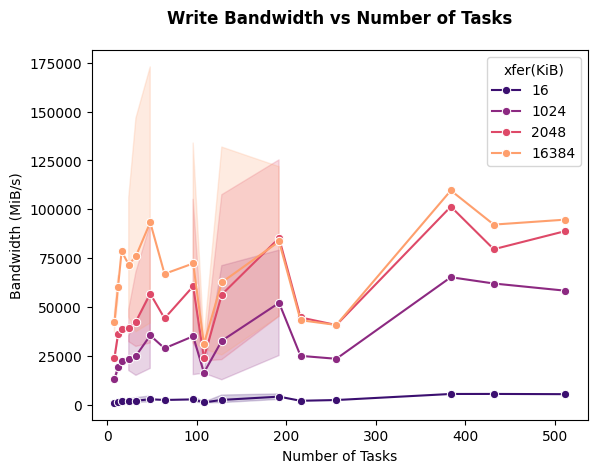

<Figure size 640x480 with 0 Axes>

In [59]:
palette = sns.color_palette("magma", len(df["xfer(KiB)"].unique()))
ax = sns.lineplot(
                data=df,
                x="numTasks",
                y="bw(MiB/s)",
                hue="xfer(KiB)",
                # style="rand_seq_type", dashes=dashes,
                marker='o',
                # hue_order=hue_order,
                # order=bs_order,
                palette=palette
            )
# ax.set_xticks(subdf["job options.numjobs"].unique())
ax.set_xlabel("Number of Tasks")
ax.set_ylabel("Bandwidth (MiB/s)")
ax.set_title("Write Bandwidth vs Number of Tasks", weight="bold", x=0.5, y=1.05)
plt.show()
plt.clf() 

AttributeError: Line2D.set() got an unexpected keyword argument 'order'

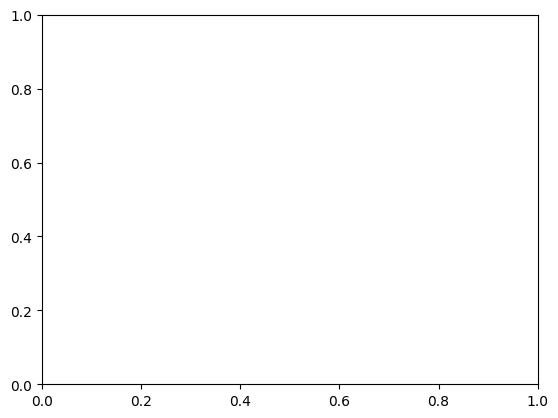

In [ ]:
for n in df['nnodes'].unique():
    subdf = df[df['nnodes']==n]
    palette = sns.color_palette("magma", len(df["xfer(KiB)"].unique()))
    ax = sns.lineplot(
                    data=subdf,
                    x="numTasks",
                    y="bw(MiB/s)",
                    hue="xfer(KiB)",
                    # style="rand_seq_type", dashes=dashes,
                    marker='o',
                    # hue_order=hue_order,
                    # order=xfer_order,
                    palette=palette
                )
    # ax.set_xticks(subdf["job options.numjobs"].unique())
    ax.set_xlabel("Number of Tasks")
    ax.set_ylabel("Bandwidth (MiB/s)")
    ax.set_title("Write Bandwidth vs Number of Tasks", weight="bold", x=0.5, y=1.05)
    ax.text(x=0.5, y=1.01, 
                    s=f"# Nodes = {n}, b = {df['block(KiB)'].unique()[0]}, s = {df['segments'].unique()}", 
                    fontsize=10, alpha=0.75, ha='center', va='bottom', 
                    transform=ax.transAxes)
    plt.show()
    plt.clf() 

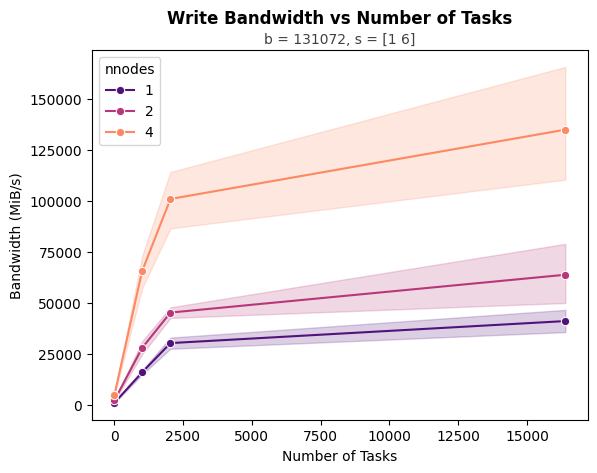

<Figure size 640x480 with 0 Axes>

In [69]:

palette = sns.color_palette("magma", len(df["nnodes"].unique()))
ax = sns.lineplot(
                data=df,
                x="xfer(KiB)",
                y="bw(MiB/s)",
                hue="nnodes",
                # style="rand_seq_type", dashes=dashes,
                marker='o',
                # hue_order=hue_order,
                # order=xfer_order,
                palette=palette
            )
# ax.set_xticks(subdf["job options.numjobs"].unique())
ax.set_xlabel("Number of Tasks")
ax.set_ylabel("Bandwidth (MiB/s)")
ax.set_title("Write Bandwidth vs Number of Tasks", weight="bold", x=0.5, y=1.05)
ax.text(x=0.5, y=1.01, 
                s=f"b = {df['block(KiB)'].unique()[0]}, s = {df['segments'].unique()}", 
                fontsize=10, alpha=0.75, ha='center', va='bottom', 
                transform=ax.transAxes)
plt.show()
plt.clf() 

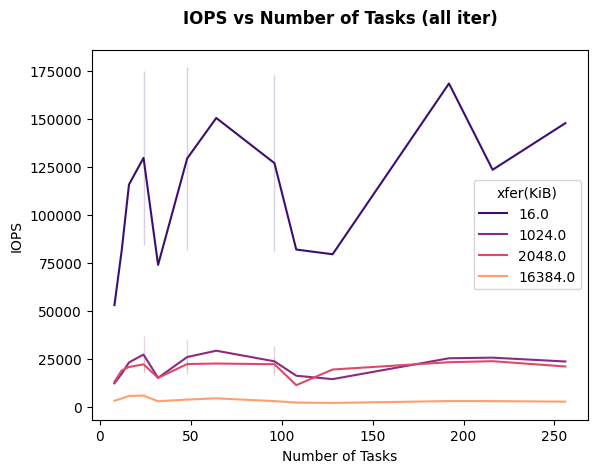

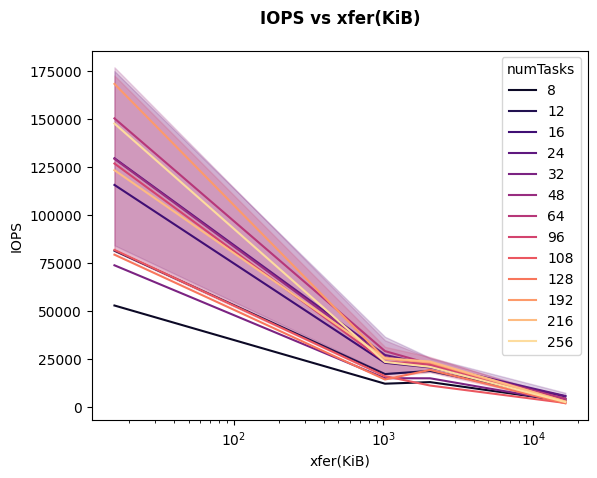

<Figure size 640x480 with 0 Axes>

In [38]:
palette = sns.color_palette("magma", len(df["xfer(KiB)"].unique()))
ax = sns.lineplot(
                data=df,
                x="numTasks",
                y="IOPS",
                hue="xfer(KiB)",
                # style="rand_seq_type", dashes=dashes,
                # marker='o',
                # hue_order=hue_order,
                # order=bs_order,
                palette=palette
            )
# ax.set_xticks(subdf["job options.numjobs"].unique())
ax.set_xlabel("Number of Tasks")
ax.set_ylabel("IOPS")
ax.set_title("IOPS vs Number of Tasks (all iter)", weight="bold", x=0.5, y=1.05)
plt.show()
plt.clf() 
palette = sns.color_palette("magma", len(df["numTasks"].unique()))
ax = sns.lineplot(
                data=df,
                x="xfer(KiB)",
                y="IOPS",
                hue="numTasks",
                # style="rand_seq_type", dashes=dashes,
                # marker='o',
                # hue_order=hue_order,
                # order=bs_order,
                palette=palette
            )
# ax.set_xticks(subdf["job options.numjobs"].unique())
ax.set_xlabel("xfer(KiB)")
ax.set_ylabel("IOPS")
plt.xscale('log')
ax.set_title("IOPS vs xfer(KiB)", weight="bold", x=0.5, y=1.05)
plt.show()
plt.clf() 

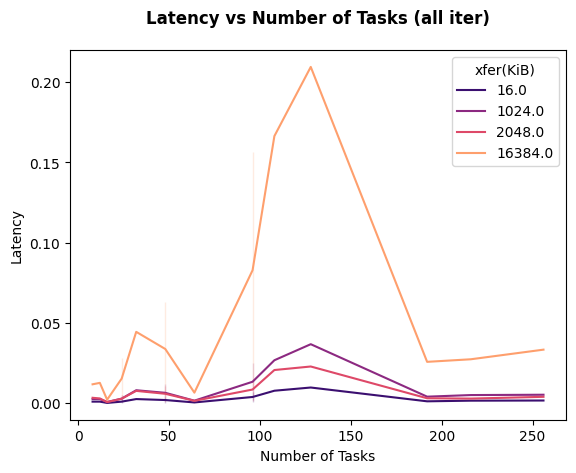

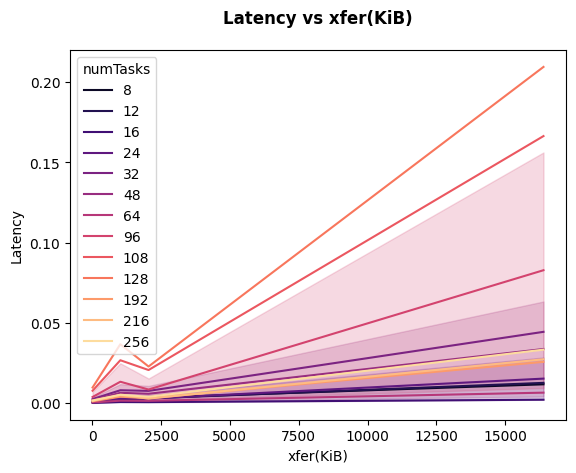

<Figure size 640x480 with 0 Axes>

In [ ]:
palette = sns.color_palette("magma", len(df["xfer(KiB)"].unique()))
ax = sns.lineplot(
                data=df,
                x="numTasks",
                y="Latency",
                hue="xfer(KiB)",
                # style="rand_seq_type", dashes=dashes,
                # marker='o',
                # hue_order=hue_order,
                # order=bs_order,
                palette=palette
            )
# ax.set_xticks(subdf["job options.numjobs"].unique())
ax.set_xlabel("Number of Tasks")
ax.set_ylabel("Latency")
ax.set_title("Latency vs Number of Tasks", weight="bold", x=0.5, y=1.05)
plt.show()
plt.clf() 
palette = sns.color_palette("magma", len(df["numTasks"].unique()))
ax = sns.lineplot(
                data=df,
                x="xfer(KiB)",
                y="Latency",
                hue="numTasks",
                # style="rand_seq_type", dashes=dashes,
                # marker='o',
                # hue_order=hue_order,
                # order=bs_order,
                palette=palette
            )
# ax.set_xticks(subdf["job options.numjobs"].unique())
ax.set_xlabel("xfer(KiB)")
ax.set_ylabel("Latency")
ax.set_title("Latency vs xfer(KiB)", weight="bold", x=0.5, y=1.05)
plt.show()
plt.clf() 

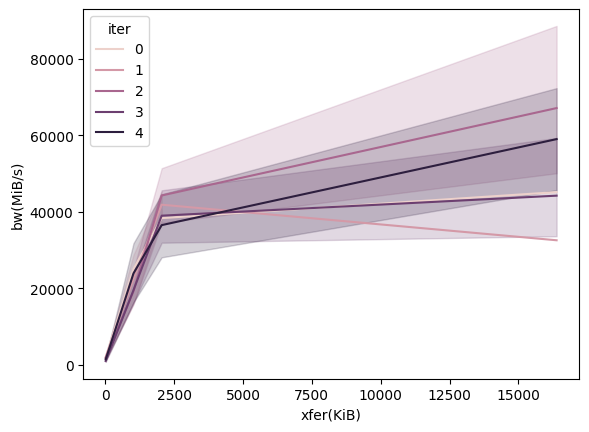

In [ ]:
palette = sns.color_palette("magma", len(df["iter"].unique()))
ax = sns.lineplot(
                data=df,
                x="xfer(KiB)",
                y="bw(MiB/s)",
                hue="iter",
                # style="rand_seq_type", dashes=dashes,
                # marker='o',
                # hue_order=hue_order,
                # order=bs_order,
                # palette=palette
            )
ax.set_xlabel("Number of Tasks")
ax.set_ylabel("Bandwidth (MiB/s)")
ax.set_title("Bandwidth vs Number of Tasks (all iter)", weight="bold", x=0.5, y=1.05)
plt.show()
plt.clf() 